### Parameterisation Analysis

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d
import scipy.stats as ss
from collections import OrderedDict

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

import gcm_filters

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:33497 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

#### Load important params


In [4]:
year = '2170'
expt = '01deg_jra55v13_ryf9091'

start_time= year + '-01-01'
end_time= year + '-12-31'

# reference density value:
rho_0 = 1035.0
g = 9.81

In [5]:
## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)


In [6]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)


CPU times: user 1.57 s, sys: 472 ms, total: 2.05 s
Wall time: 14.9 s


In [7]:
%%time

dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
dyt = dyt.sel(yt_ocean = lat_range)
dxt = cc.querying.getvar(expt,'dxt',session,ncfile = 'ocean_grid.nc',n=1)
dxt = dxt.sel(yt_ocean = lat_range)

CPU times: user 585 ms, sys: 224 ms, total: 808 ms
Wall time: 12.1 s


In [8]:
contour_dict = OrderedDict([
    ('A',  {'SSH':-0.1,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.1m_SSH.npz','shifted':False}),
    ('B',  {'SSH':-0.2,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.2m_SSH.npz','shifted':False}),
    ('C',  {'SSH':-0.3,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.3m_SSH.npz','shifted':False}),
    ('D',  {'SSH':-0.4,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.4m_SSH.npz','shifted':False}),
    ('E',  {'SSH':-0.5,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.5m_SSH.npz','shifted':False}),
    ('F',  {'SSH':-0.6, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.6m_SSH.npz','shifted':False}),
    ('G',  {'SSH':-0.7, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.7m_SSH.npz','shifted':False}),
    ('H',  {'SSH':-0.8, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.8m_SSH.npz','shifted':False}),
    ('I',  {'SSH':-0.9, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.9m_SSH.npz','shifted':False}),
    ('J',  {'SSH':-1.0, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.0m_SSH.npz','shifted':False}),
    ('K',  {'SSH':-1.1, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.1m_SSH.npz','shifted':False}),
    ('L',  {'SSH':-1.2, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.2m_SSH.npz','shifted':False}),
    ('M',  {'SSH':-1.3, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.3m_SSH.npz','shifted':False}),
    ('N',  {'SSH':-1.4, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.4m_SSH.npz','shifted':False}),
    ('O',  {'SSH':-1.5, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.5m_SSH.npz','shifted':True}),
    ('P',  {'SSH':-0.15,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.15m_SSH.npz','shifted':False}),
    ('Q',  {'SSH':-0.25,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.25m_SSH.npz','shifted':False}),
    ('R',  {'SSH':-0.35,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.35m_SSH.npz','shifted':False}),
    ('S',  {'SSH':-0.45,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.45m_SSH.npz','shifted':False}),
    ('T',  {'SSH':-0.55,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.55m_SSH.npz','shifted':False}),
    ('U',  {'SSH':-0.65, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.65m_SSH.npz','shifted':False}),
    ('V',  {'SSH':-0.75, 'lat_range':slice(-61,-39.98),'lat_range_big':slice(-61.05,-39.90),'slope_path':'SO_slope_contour_-0.75m_SSH.npz','shifted':False}),
    ('W',  {'SSH':-0.85,'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.85m_SSH.npz','shifted':False}),
    ('X',  {'SSH':-0.95, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.95m_SSH.npz','shifted':False}),
    ('Y',  {'SSH':-1.05, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.05m_SSH.npz','shifted':False}),
    ('Z',  {'SSH':-1.15, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.15m_SSH.npz','shifted':False}),
    ('Z1',  {'SSH':-1.25, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.25m_SSH.npz','shifted':False}),
    ('Z2',  {'SSH':-1.35, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.35m_SSH.npz','shifted':False}),
    ('Z3',  {'SSH':-1.45, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.45m_SSH.npz','shifted':True}),
    ('Z4',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_A.npz','shifted':True}),
    ('Z5',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_B.npz','shifted':True}),
    ('Z6',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_A.npz','shifted':True}),
    ('Z7',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_B.npz','shifted':True}),
    ('Z8',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_A.npz','shifted':True}),
    ('Z9',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_B.npz','shifted':True}),
])

In [9]:
def find_lower_upper_indices(hotspot, j_contour):
    hotspot_dict = OrderedDict([
    ('PAR',  {'lower_lon':-160,'upper_lon':-110}),
    ('SWIR',  {'lower_lon':10,'upper_lon':50}),
    ('DP',  {'lower_lon':-70,'upper_lon':0}),
    ('MR',  {'lower_lon':-220,'upper_lon':-170}),
    ('KP1',  {'lower_lon':60,'upper_lon':80}),
    ('KP2',{'lower_lon':-280,'upper_lon':-260})])
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
        prefix = 400
    else:
        suffix = ''
        prefix = 0
    vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
    lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lon_along_contour
    
    if hotspot =='MR' and j_contour == 'A' or 'B' or 'J' or 'L' or 'N':
        lon_along_contour[1]=-279.95
    for i in np.arange(prefix,len(lon_along_contour)):
        if lon_along_contour[i]>hotspot_dict[hotspot]['lower_lon']:
            lower_index = i
            break
    for i in np.arange(prefix,len(lon_along_contour)):
        if lon_along_contour[i]<hotspot_dict[hotspot]['upper_lon']:
            upper_index = i
        elif lon_along_contour[i]>hotspot_dict[hotspot]['upper_lon']:
            break
    return lower_index, upper_index



In [10]:
#plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 12})


In [11]:
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)
plt.rcParams.update({'font.size': 12})


#### Find linear regression for all contours between SSH=-0.8 and -1.5 in circumpolar upwelling arm density range

I
X
J
Y
K
Z
Z1
M
Z2
N
Z3
O
L
0.5780223647058832
0.5939732706365135
0.5750531527455276


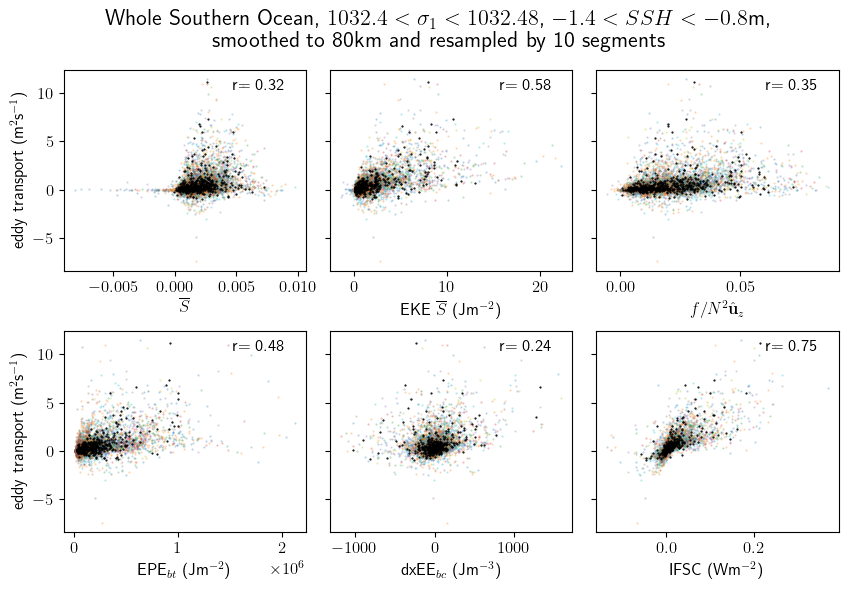

In [13]:
fig,axes = plt.subplots(nrows = 2, ncols = 3, figsize = (10,6), sharey=True)
xs_1 = np.zeros(1)
ys_1 = np.zeros(1)
xs_2 = np.zeros(1)
ys_2 = np.zeros(1)
xs_3 = np.zeros(1)
ys_3 = np.zeros(1)
xs_4 = np.zeros(1)
ys_4 = np.zeros(1)
xs_5 = np.zeros(1)
ys_5 = np.zeros(1)
xs_6 = np.zeros(1)
ys_6 = np.zeros(1)
xs_7 = np.zeros(1)
ys_7 = np.zeros(1)
xs_8 = np.zeros(1)
ys_8 = np.zeros(1)

for j in np.array([16,17,18,19,20,21,23,24,25,26,27,28,22]):
    N = 10
    colors = ['C0','C1','C2','C3','C4','C10','k','C8','C10','C7','C9','C11','C5','C12','C13','C14'][j-16]
    j_contour = np.array(['A','P','B','Q','C','R','D','S','E','T','F','U','G','V','H','W','I','X','J','Y',
                                  'K','Z','L','Z1','M','Z2','N','Z3','O','Z4','Z5','Z6','Z7','Z8','Z9'])[j]
    print(j_contour)
    if j ==22:
        alpha=1
    else:
        alpha = 0.3
    #hotspot = 'SWIR'
    #lower_index, upper_index=find_lower_upper_indices(hotspot, j_contour)
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
        segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'segment_length'+suffix+'.nc').segment_length
    else:
        suffix = ''
        segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length'+suffix+'.nc').segment_length
    vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
    lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lon_along_contour
    Form_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies_10yr_smoothed_80km'+suffix+'.nc').Form_contour
    EKE_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies_10yr_smoothed_80km'+suffix+'.nc').EKE_contour
    #Reynolds_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies'+suffix+'.nc').Reynolds_contour
    #top_rho1_max_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').top_rho1_max_contour
    #bottom_rho1_min_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').bottom_rho1_min_contour
    h_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/h_bar_contour_SO_'+j_contour+suffix+'.nc').h_bar
    #Omega = 7.2921150*10**(-5) #rad/s
    g = 9.81
    rho_0 = 1035
    #f = 2 * Omega*np.sin(lat_along_contour*(2*np.pi)/360)
    rho_along_contour = h_along_contour*0+h_along_contour.isopycnal_bins
    rho_along_contour_roll1 = rho_along_contour.roll(isopycnal_bins = 1, roll_coords = False)  
    h_along_contour_roll1 = h_along_contour.roll(isopycnal_bins = 1, roll_coords = False)  
    drho_dz = (rho_along_contour-rho_along_contour_roll1)/(h_along_contour_roll1+h_along_contour)*2
    Nsquared = (g/rho_along_contour*drho_dz)    

    Depth_gradient = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_depth_gradient_smoothed80km'+suffix+'.nc').depth_grad_contour
    EPE_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_EPE_contour_smoothed_80km'+suffix+'.nc').EPE_contour
    EPE_bc_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_EPE_contour_smoothed_80km_fulldepth'+suffix+'.nc').EPE_contour
    T_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_GL90_smoothed80km'+suffix+'.nc').T_eddy
    
    rhoslice = slice(1032.2,1032.5)
    h = h_along_contour.sel(isopycnal_bins = rhoslice)#.sum('isopycnal_bins').values
    y = uniform_filter1d(-vh_eddy.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins'), size=N) #[lower_index:upper_index]
    y = y#[lower_index:upper_index]
    y2 = np.zeros(np.floor(len(y)/10).astype(int))
    for i in np.arange(0,np.floor(len(y)/10).astype(int)):
        y2[i]=(y)[10*i:10+10*i].sum()/(segment_length[10*i:10+10*i].sum())

    x = Depth_gradient.sel(isopycnal_bins = rhoslice)#.sum('isopycnal_bins').values
    x = (x*h).sum('isopycnal_bins')/h.sum('isopycnal_bins')
    x = x#[lower_index:upper_index]
    x2 = np.zeros(np.floor(len(x)/10).astype(int))
    for i in np.arange(0,np.floor(len(x)/10).astype(int)):
        x2[i]=(x*segment_length)[10*i:10+10*i].sum()/(segment_length[10*i:10+10*i].sum())
    axes[0,0].scatter(x2,y2, color = colors, s = 0.3,alpha = alpha)
    r,p = ss.pearsonr(x2,y2)
    xs_1 = np.append(x2,xs_1)
    ys_1 = np.append(y2,ys_1)

    x = Depth_gradient.sel(isopycnal_bins = rhoslice)#.sum('isopycnal_bins').values        
    z = EKE_contour.sel(isopycnal_bins = rhoslice)/segment_length#.sum('isopycnal_bins').values
    x = (x*z*h).sum('isopycnal_bins')/h.sum('isopycnal_bins')#[lower_index:upper_index]
    x2 = np.zeros(np.floor(len(x)/10).astype(int))
    for i in np.arange(0,np.floor(len(x)/10).astype(int)):
        x2[i]=(x*segment_length)[10*i:10+10*i].sum()/(segment_length[10*i:10+10*i].sum())
    axes[0,1].scatter(x2,y2, color = colors, s = 0.3,alpha = alpha)
    r,p = ss.pearsonr(x2,y2)
    xs_2 = np.append(x2,xs_2)
    ys_2 = np.append(y2,ys_2)
    
#     x = (Depth_gradient*Nsquared).sel(isopycnal_bins = rhoslice)#.sum('isopycnal_bins').values#[lower_index:upper_index]
#     x = (x*h).sum('isopycnal_bins')/h.sum('isopycnal_bins')
#     x = x#[lower_index:upper_index]
#     x2 = np.zeros(np.floor(len(x)/10).astype(int))
#     for i in np.arange(0,np.floor(len(x)/10).astype(int)):
#         x2[i]=(x*segment_length)[10*i:10+10*i].sum()/(segment_length[10*i:10+10*i].sum())
#     axes[0,2].scatter(x2,y2, color = colors, s = 0.3,alpha = alpha)
#     r,p = ss.pearsonr(x2,y2)
#     xs_3 = np.append(x2,xs_3)
#     ys_3 = np.append(y2,ys_3)

    x = T_eddy.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
    x = -x#[lower_index:upper_index]
    x2 = np.zeros(np.floor(len(x)/10).astype(int))
    for i in np.arange(0,np.floor(len(x)/10).astype(int)):
        x2[i]=(x*segment_length)[10*i:10+10*i].sum()/(segment_length[10*i:10+10*i].sum())
    axes[0,2].scatter(x2,y2, color = colors, s = 0.3,alpha = alpha)
    r,p = ss.pearsonr(x2,y2)
    xs_4 = np.append(x2,xs_4)
    ys_4 = np.append(y2,ys_4)    

    x = EPE_contour
    x = x#[lower_index:upper_index]
    x2 = np.zeros(np.floor(len(x)/10).astype(int))
    for i in np.arange(0,np.floor(len(x)/10).astype(int)):
        x2[i]=(x*segment_length)[10*i:10+10*i].sum()/(segment_length[10*i:10+10*i].sum())
    axes[1,0].scatter(x2,y2, color = colors, s = 0.3,alpha = alpha)
    r,p = ss.pearsonr(x2,y2)
    xs_5 = np.append(x2,xs_5)
    ys_5 = np.append(y2,ys_5)

#     x = EPE_bc_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
#     x = x#[lower_index:upper_index]
#     x2 = np.zeros(np.floor(len(x)/10).astype(int))
#     for i in np.arange(0,np.floor(len(x)/10).astype(int)):
#         x2[i]=(x*segment_length)[10*i:10+10*i].sum()/(segment_length[10*i:10+10*i].sum())
#     axes[1,2].scatter(x2,y2, color = colors, s = 0.3,alpha = alpha)
#     r,p = ss.pearsonr(x2,y2)
#     xs_6 = np.append(x2,xs_6)
#     ys_6 = np.append(y2,ys_6)
    

    x = (EPE_bc_contour+EKE_contour).sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').fillna(0)
    x = x#[lower_index:upper_index]
    x2 = np.zeros(np.floor(len(x)/10).astype(int))
    segments = np.zeros(np.floor(len(x)/10).astype(int))
    for i in np.arange(0,np.floor(len(x)/10).astype(int)):
        x2[i]=(x*segment_length)[10*i:10+10*i].sum()/(segment_length[10*i:10+10*i].sum())
        segments[i]=segment_length[10*i:10+10*i].sum()
    x2 = np.diff(x2)
    x2 = np.append(x2,0)
    x2 = x2/(segments+np.roll(segments,1))*2
    axes[1,1].scatter(x2,y2, color = colors, s = 0.3,alpha = alpha)
    r,p = ss.pearsonr(x2,y2)
    xs_7 = np.append(x2,xs_7)
    ys_7 = np.append(y2,ys_7)
    
    x = Form_contour.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')/segment_length
    x = x#[lower_index:upper_index]
    x2 = np.zeros(np.floor(len(x)/10).astype(int))
    for i in np.arange(0,np.floor(len(x)/10).astype(int)):
        x2[i]=(x*segment_length)[10*i:10+10*i].sum()/(segment_length[10*i:10+10*i].sum())
    axes[1,2].scatter(x2,y2, color = colors, s = 0.3,alpha = alpha)
    r,p = ss.pearsonr(x2,y2)
    xs_8 = np.append(x2,xs_8)
    ys_8 = np.append(y2,ys_8)


r,p = ss.pearsonr(xs_1,ys_1)
axes[0,0].text(0.7,0.9,'r= '+"{:.2f}".format(r),transform=axes[0,0].transAxes)

r,p = ss.pearsonr(xs_2,ys_2)
print(r)
r,p = ss.pearsonr(np.roll(xs_2,-1),ys_2)
print(r)
r,p = ss.pearsonr(np.roll(xs_2,-2),ys_2)
print(r)

r,p = ss.pearsonr(xs_2,ys_2)
axes[0,1].text(0.7,0.9,'r= '+"{:.2f}".format(r),transform=axes[0,1].transAxes)
# r,p = ss.pearsonr(xs_3,ys_3)
# axes[0,2].text(0.7,0.9,'r= '+"{:.2f}".format(r),transform=axes[0,2].transAxes)
r,p = ss.pearsonr(xs_4,ys_4)
axes[0,2].text(0.7,0.9,'r= '+"{:.2f}".format(r),transform=axes[0,2].transAxes)
r,p = ss.pearsonr(xs_5,ys_5)
axes[1,0].text(0.7,0.9,'r= '+"{:.2f}".format(r),transform=axes[1,0].transAxes)
# r,p = ss.pearsonr(xs_6,ys_6)
# axes[1,2].text(0.7,0.9,'r= '+"{:.2f}".format(r),transform=axes[1,2].transAxes)
r,p = ss.pearsonr(xs_7,ys_7)
axes[1,1].text(0.7,0.9,'r= '+"{:.2f}".format(r),transform=axes[1,1].transAxes)
r,p = ss.pearsonr(xs_8,ys_8)
axes[1,2].text(0.7,0.9,'r= '+"{:.2f}".format(r),transform=axes[1,2].transAxes)

axes[0,0].set_title('')#Gent-McWilliams')
axes[0,1].set_title('')#eddy diffusivity $\propto$ EKE')
axes[0,2].set_title('')#eddy diffusivity $\propto N^2$')
axes[1,0].set_title('')#Greatbatch \& Lamb')
axes[1,1].set_title('')#barotropic EPE')
axes[1,2].set_title('')#baroclinic EPE')
#axes[2,0].set_title('')#eddy energy growth')
#axes[2,1].set_title('')#IFSC')

axes[0,0].set_xlabel('$\overline{S}$')
axes[0,1].set_xlabel('EKE $\overline{S}$ (Jm$^{-2}$)'  )
# axes[0,2].set_xlabel('$N^2\overline{S}$ (s$^{-2}$)')
axes[0,2].set_xlabel('$f/N^2\hat{\mathbf{u}}_z$')
axes[1,0].set_xlabel('EPE$_{bt}$ (Jm$^{-2}$)')
# axes[1,2].set_xlabel('EPE$_{bc}$ (Jm$^{-2}$)')
axes[1,1].set_xlabel('dxEE$_{bc}$ (Jm$^{-3}$)')
axes[1,2].set_xlabel('IFSC (Wm$^{-2}$)')

axes[0,0].set_ylabel('eddy transport (m$^2$s$^{-1}$)')
axes[1,0].set_ylabel('eddy transport (m$^2$s$^{-1}$)')
#axes[2,0].set_ylabel('eddy transport (m$^2$s$^{-1}$)')

#axes[0,2].set_xlim(-2e-8,4e-8)
#axes[1,2].set_xlim(-1e6,8e6)
fig.suptitle('Whole Southern Ocean, $1032.4<\sigma_1<1032.48$, $-1.4<SSH<-0.8$m,\n smoothed to 80km and resampled by 10 segments', fontsize = 16)
#axes[2,2].axis('off')
fig.subplots_adjust(hspace = 0.3)
fig.subplots_adjust(wspace = 0.1)

#fig.savefig('Parameterisation_analysis.png',dpi = 400)